<a href="https://colab.research.google.com/github/ajaynain-eng/2D-to-3D-CNN-Pivotal-Teleradiology/blob/main/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import os
 os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d ymirsky/medical-deepfakes-lung-cancer 

100% 5.98G/5.99G [01:27<00:00, 41.8MB/s]
100% 5.99G/5.99G [01:28<00:00, 73.0MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

In [ ]:
!pip install pydicom

In [ ]:
# importing supporting libraries
import pandas as pd                    # to create and read data frame and series
import numpy as np                     # to work with array
from matplotlib import pyplot as plt   # to plot figures
import seaborn as sns                  # to plot interactive metric plot and heatmaps
import cv2                             # to read and show image
from skimage.transform import resize   # as we need to resize the image to reduce model complexity and get optimum accuracy

In [ ]:
import warnings
import pydicom as dicom
import glob

In [ ]:
# importing required CNN algorithms, optimizers and activation function
import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from keras import Sequential
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPool3D, ZeroPadding3D, Dropout, BatchNormalization
from keras.layers import Flatten, Dense, Input
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras import callbacks
# importing pretrained model VGG16
from keras.applications import VGG16

In [ ]:
from skimage import measure
from skimage.transform import resize
from matplotlib.projections import Axes3D
from plotly.figure_factory import create_trisurf
from mpl_toolkits import mplot3d

In [ ]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

def crop_image(image, display=False):
# Create a mask with the background pixels
    mask = image == 0
# Find the lung area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
# Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                         top_left[1]:bottom_right[1]]
    return croped_image

In [ ]:
def no_crop(medical_img):         # changes the medical image in pixel array and returns the original image
    return medical_img.pixel_array

def crop_the_image_1(medical_img):     # crop the image corresponding to HU range for lungs
    temp_medical_img = medical_img
    temp_img = temp_medical_img.pixel_array
    hu_image = transform_to_hu(temp_medical_img,temp_img)
    lung_image = window_image(hu_image, -500, 1500)
    croped_img = crop_image(lung_image, display=False)
    return croped_img

In [ ]:
def get_data(pid, crop_function):         #  Selects and crops 110 slices and give 3D and 2D image data
    files = glob.glob("/content/CT_Scans/EXP1_blind/"+ pid +"/*.dcm")
    slices = [dicom.read_file(i) for i in files]
    slices = sorted(slices, key=lambda s: s.SliceLocation)
    s = 0
    views = np.empty([110,110,110])
    x = (len(slices)-4)/109      # Select 110 slices
    for i in range(110):
        t = int(4+(x*i))
        try:
            t_img = crop_function(slices[t])
            t_img = resize(t_img, (110,110))
        except:
            t_img = crop_function(slices[t-1])
            t_img = resize(t_img, (110,110))
            s = s + 1
        views[:,:,i] = t_img          # 3D image array
        i += 1
    img_2d = views[55,:,:].T
    img_2d = img_2d[::-1]           # 2D image array
    print(s)     
    return views, img_2d

In [ ]:
patients_id = os.listdir('/content/CT_Scans/EXP1_blind')

In [ ]:
f = patients_id.copy()
g2d_0 = np.zeros((80,110,110))
views_0 = np.zeros((80,110,110,110))
fcount_0 = []
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, no_crop)
    g2d_0[i] = img_2d
    views_0[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_0 = g2d_0
y_0 = views_0
np.save('Data_out_0.npy', views_0)              # Temprory storing the data in drive
np.save('Data_in_0.npy', g2d_0)

0
0
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
0
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
0
21
1
22
1
23
1
24
1
25
1
26
1
27
1
28
1
29
1
30
1
31
1
32
0
33
1
34
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
1
43
1
44
0
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
0
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
1
69
1
70
1
71
1
72
1
73
1
74
1
75
1
76
1
77
1
78
1
79
1


In [ ]:
f = patients_id.copy()
g2d_1 = np.zeros((80,110,110))
views_1 = np.zeros((80,110,110,110))
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, crop_the_image_1)
    g2d_1[i] = img_2d
    views_1[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_1 = g2d_1
y_1 = views_1
np.save('Data_out_1.npy', views_1)
np.save('Data_in_1.npy', g2d_1)

0
0
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
0
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
0
21
1
22
1
23
1
24
1
25
1
26
1
27
1
28
1
29
1
30
1
31
1
32
0
33
1
34
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
1
43
1
44
0
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
0
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
1
69
1
70
1
71
1
72
1
73
1
74
1
75
1
76
1
77
1
78
1
79
1


In [ ]:
x_0 = np.load('/content/Data_in_0.npy')
y_0 = np.load('/content/Data_out_0.npy')
x_1 = np.load('/content/Data_in_1.npy')
y_1 = np.load('/content/Data_out_1.npy')

In [ ]:
def plot_learning_curve(model, epochs):   
    plt.figure(figsize=(15,6))
    plt.plot(np.arange(0,epochs), model.history['accuracy'], color = 'green', label = 'train_accuracy')
    plt.plot(np.arange(0,epochs), model.history['loss'], color = 'red', label = 'train_loss')
    plt.plot(np.arange(0,epochs), model.history['val_accuracy'], color = 'blue', label = 'test_accuracy')
    plt.plot(np.arange(0,epochs), model.history['val_loss'], color = 'black', label = 'test_loss')
    plt.grid()
    plt.xlabel('no. of epochs')
    plt.ylabel('accuracy and loss')
    plt.legend(loc = 'lower right')

def plot_accuracy_curve(model, epochs):    
    plt.figure(figsize=(15,6))
    plt.plot(np.arange(0,epochs), model.history['accuracy'], color = 'green', label='accuracy')
    plt.plot(np.arange(0,epochs), model.history['val_accuracy'], color = 'red', label = 'test accuracy')
    plt.grid()
    plt.legend(loc = 'lower right')

In [ ]:
x_train_0 = x_0[:66]
x_test_0 = x_0[65:]
y_train_0 = y_0[:66]
y_test_0 = y_0[65:]

x0 = x_train_0[:,1,:]
y0 = y_train_0[:,:,:,1]
x_test0 = x_test_0[:,1,:]
y_test0 = y_test_0[:,:,:,1]

In [ ]:
x_train_1 = x_1[:66]
x_test_1 = x_1[65:]
y_train_1 = y_1[:66]
y_test_1 = y_1[65:]

x1 = x_train_1[:,1,:]
y1 = y_train_1[:,:,:,1]
x_test1 = x_test_1[:,1,:]
y_test1 = y_test_1[:,:,:,1]

In [ ]:
x_test0 = x_test0.reshape(15,110,1)
x0 = x0.reshape(66,110,1)

x_test1 = x_test1.reshape(15,110,1)
x1 = x1.reshape(66,110,1)

In [ ]:
x0.shape, y0.shape

((66, 110, 1), (66, 110, 110))

In [ ]:
def getPixels(curr, dist, img):
    res = [img[curr[0]][curr[1]]]
    res += img[curr[0]-dist][curr[1]-dist:curr[1]+dist].tolist()
    res += img[curr[0]+dist][curr[1]-dist:curr[1]+dist].tolist()
    for i in range(-dist+1, dist):
        res.append(img[curr[0]+i][curr[1]+dist])
        res.append(img[curr[0]+i][curr[1]-dist])
    return res


def getDf(df, data_0, snum = 4, curr=[50,50], dist=10):
    df = pd.DataFrame(columns = np.arange(0,79))
    df_sn = data_0[['x_ray', 'slice_' + str(snum)]]
    l = list()
    for i in range(len(df_sn)):
        xry = df_sn['x_ray'][i]
        sl = df_sn['slice_'+str(snum)][i]
        inp = getPixels(curr, dist, xry)
        op = sl[curr[0]][curr[1]]
        df.loc[len(df)] = inp
        l.append(op)
        #df.loc[len(df)] = inp + op
        #df = filterImg(xry, sl, curr, dist, df)
    df = pd.concat([df, pd.Series(l, name=79)], axis = 1)
    return df

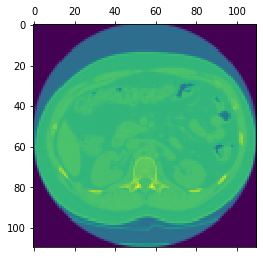

In [ ]:
plt.matshow(y0[0])

In [ ]:
d = dict()
d['x_ray'] = [x_train_0[i] for i in range(66)]
for j in range(110):
    d['slice_' + str(j)] = [y_train_0[:,:,:,j][i] for i in range(66)]
data_0 = pd.DataFrame(d)

#data_0

In [ ]:
d = dict()
d['x_ray'] = [x_test_0[i] for i in range(len(x_test_0))]
for j in range(110):
    d['slice_' + str(j)] = [y_test_0[:,:,:,j][i] for i in range(len(y_test_0))]
data_0_test = pd.DataFrame(d)

#data_0_test

In [ ]:
df = pd.DataFrame(columns = np.arange(0,79))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78


In [ ]:
temp_train = getDf(df, data_0)

In [ ]:
temp_test = getDf(df, data_0_test)

In [ ]:
temp_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
0,-0.002190,-0.025904,-0.025083,-0.007748,0.000847,0.001694,0.001767,0.001209,0.001094,0.001341,0.001576,0.001632,0.001316,0.001504,0.001598,0.001714,0.001511,0.001653,0.001592,0.001382,0.000819,0.002140,-0.001300,-0.013367,-0.024153,-0.024916,-0.025846,-0.025756,-0.026216,-0.025590,-0.024624,-0.016160,-0.006573,-0.000535,0.001002,0.000838,0.000834,0.000850,0.000349,-0.000890,-0.002170,-0.002147,-0.025228,-0.002731,-0.022314,-0.000908,-0.024258,0.000473,-0.025519,0.000410,-0.025534,0.000831,-0.025800,0.001619,-0.021861,0.001543,-0.022238,0.001163,-0.021587,0.001306,-0.023224,0.001237,-0.022825,0.001333,-0.024190,0.001414,-0.023294,0.001197,-0.023323,0.001286,-0.023451,0.001195,-0.024929,0.001200,-0.025203,0.001069,-0.023629,0.000230,-0.009020,-0.000636
1,-0.023521,-0.026319,-0.024624,-0.026201,-0.025500,-0.023256,-0.017451,-0.018498,-0.023632,-0.027345,-0.027048,-0.025569,-0.025444,-0.016668,-0.005626,-0.001241,-0.003223,-0.003857,0.000330,0.005691,0.007263,-0.024901,-0.021987,-0.021594,-0.025853,-0.017876,0.000685,-0.005220,-0.018597,-0.024058,-0.019711,-0.007954,-0.002562,-0.001495,-0.001879,-0.003455,0.001063,0.005043,0.005803,0.006128,0.005900,0.008088,-0.025410,0.007798,-0.023648,0.007318,-0.021839,0.007102,-0.022057,0.007076,-0.016543,0.006851,-0.017773,0.007092,-0.015997,0.006984,-0.022456,0.006982,-0.024557,0.006710,-0.025046,0.006951,-0.019033,0.006855,-0.023394,0.006822,-0.024734,0.006545,-0.024092,0.006218,-0.022050,0.006562,-0.024816,0.006405,-0.012292,0.006324,-0.023470,0.005977,-0.023941,0.003450
2,0.000959,-0.024785,-0.026430,-0.025777,-0.013031,0.000408,0.003841,0.004213,0.001974,0.001406,-0.015960,-0.027059,-0.023755,-0.002951,0.004010,0.003100,0.002828,0.001571,-0.000141,0.000264,0.001769,-0.026742,-0.023185,-0.020389,-0.028047,-0.028466,-0.027892,-0.021024,-0.024532,-0.027483,-0.026409,-0.028246,-0.025403,-0.023069,-0.016584,-0.009431,-0.003494,-0.002348,-0.001804,0.000302,0.002028,-0.000992,-0.022253,0.001117,-0.027040,0.004395,-0.026943,0.009767,-0.027116,0.010282,-0.025457,0.010758,-0.026268,0.011288,-0.025746,0.011223,-0.026176,0.011060,-0.026072,0.011870,-0.026133,0.011793,-0.025328,0.010922,-0.025324,0.010364,-0.026020,0.010404,-0.026783,0.011270,-0.026425,0.009984,-0.026374,0.008497,-0.026381,0.007403,-0.025216,0.005263,-0.024974,0.001418
3,0.001013,-0.005650,-0.020447,-0.024651,-0.007972,-0.000514,-0.001264,0.000024,0.000489,0.000859,0.000101,-0.002353,-0.000889,-0.000072,0.000328,0.000248,-0.001103,-0.002340,-0.002019,0.000847,0.001567,-0.019646,-0.024635,-0.025021,-0.021929,-0.019427,-0.016738,-0.003565,-0.002085,-0.000173,0.000517,-0.000255,-0.001258,-0.000757,0.000364,0.001165,0.001120,0.001085,0.001669,0.001587,0.001330,0.001307,0.000567,0.000726,-0.002470,0.001287,-0.018165,0.000897,-0.002189,0.000889,-0.000021,0.001032,0.000666,0.000727,0.000183,0.000779,-0.000494,0.001662,-0.001636,-0.000716,0.000138,0.000317,0.000856,0.000831,0.001230,0.000577,0.000360,0.001641,0.000009,0.001642,-0.003998,0.001354,-0.025829,0.001071,-0.006288,0.002031,-0.005759,0.001268,-0.011872,0.001205
4,-0.004186,-0.025410,-0.026052,-0.027468,-0.025774,-0.024567,-0.026004,-0.019234,-0.009707,-0.029363,-0.030020,-0.030059,-0.029930,-0.030140,-0.023674,0.001852,0.008895,0.009842,0.010031,0.010321,0.010779,-0.014840,-0.001102,0.010364,0.011401,0.011681,0.011994,0.010171,-0.003885,-0.016234,-0.011027,0.004653,0.011350,0.011341,0.011471,0.011308,0.011414,0.011566,0.008585,0.004204,-0.009103,0.000050,-0.025977,-0.002789,-0.026461,-0.003200,-0.025595,0.001402,-0.025261,0.008431,-0.026009,0.009293,-0.027554,0.008415,-0.020849,0.007921,-0.020772,0.007098,-0.026733,0.006446,-0.026256,-0.000437,-0.010633,-0.020779,0.005270,-0.028270,0.002909,-0.028529,-0.008921,-0.006540,-0.023077,-0.022119,-0.029211,-0.0

In [ ]:
temp_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
0,-0.005927,-0.024093,-0.026330,-0.027689,-0.024847,-0.020394,0.023353,0.033265,0.021026,-0.000677,0.000446,0.000960,0.001213,0.000427,-0.001211,-0.003173,-0.001241,0.007385,0.010845,0.011121,0.011456,0.000984,-0.005188,-0.025123,-0.026356,-0.026894,-0.013857,-0.003206,0.001344,0.008135,0.009511,0.009584,0.010697,0.010829,0.010781,0.010670,0.010564,0.010098,0.010137,0.009916,0.010030,0.011143,-0.020556,0.011580,-0.023994,0.011688,-0.023655,0.011853,-0.020547,0.011589,-0.002428,0.011523,-0.011984,0.011990,-0.023399,0.011645,-0.027105,0.006542,-0.025522,-0.000925,-0.023630,0.002099,-0.020547,0.005286,-0.021184,0.006129,-0.022636,0.008285,-0.011807,0.010383,-0.006334,0.008601,-0.004410,0.007782,-0.004928,0.007889,-0.009434,0.009418,-0.007652,0.004844
1,-0.002581,-0.017424,-0.019614,-0.023001,-0.024125,-0.019684,-0.005201,-0.004906,-0.024078,-0.028763,-0.027954,-0.022839,-0.004737,0.001775,0.002192,0.000544,0.000372,-0.000334,-0.001190,-0.001875,-0.002131,-0.025911,-0.022789,-0.011873,-0.013065,-0.020445,-0.023642,-0.020725,-0.009285,-0.012043,-0.018599,-0.018474,-0.004834,-0.000375,0.001021,0.001737,0.003868,0.005308,0.006260,0.006848,0.007091,0.000593,-0.025546,0.001237,-0.026814,0.004514,-0.025692,0.006379,-0.024578,0.007029,-0.018800,0.006698,-0.015634,0.006224,-0.013832,0.006394,0.000470,0.006524,0.006441,0.006693,0.006067,0.006573,0.006173,0.006819,0.002925,0.006387,-0.000832,0.006353,0.000202,0.006169,0.000093,0.006769,-0.008136,0.007263,-0.013993,0.006413,-0.018558,0.006271,-0.022068,0.000975
2,0.003949,0.002734,-0.009853,-0.027122,-0.027361,-0.026578,0.000884,0.023173,0.037070,0.033489,0.027364,0.022990,0.026366,0.020562,0.008333,0.011433,0.013282,0.012724,0.012219,0.011706,0.011418,-0.027703,-0.028196,-0.028248,-0.028540,-0.029318,-0.017881,-0.003216,-0.000565,0.005469,0.010353,0.010189,0.009587,0.009953,0.010219,0.010305,0.009610,0.009011,0.008912,0.008689,0.008853,0.012157,-0.024604,0.011774,-0.025410,0.011914,-0.026378,0.012018,-0.022924,0.003815,-0.011656,-0.000418,-0.003334,0.002816,0.005176,0.005236,0.008948,0.005677,0.006290,0.005891,-0.005197,0.005444,-0.002033,0.004190,0.001749,0.004069,-0.027091,0.004808,-0.015870,0.006843,-0.002367,0.007970,-0.011893,0.009190,-0.025017,0.009328,-0.026682,0.008977,-0.026328,0.004760
3,0.004454,-0.017399,-0.002067,0.006734,0.006129,0.002280,0.001333,0.015527,0.025478,0.046300,0.043663,0.007372,-0.002031,0.000057,0.002470,0.003985,0.004370,0.004659,0.004733,0.004849,0.004687,-0.026913,-0.023743,-0.022795,-0.026310,-0.026686,-0.026800,-0.025088,-0.008470,0.007658,0.009037,0.008041,0.007644,0.006709,0.005588,0.003877,0.001208,0.001960,0.002258,-0.001020,-0.000329,0.002950,-0.004812,0.003131,-0.005345,0.000801,-0.001906,0.000792,-0.005071,0.003187,-0.008718,0.004908,-0.014948,0.007085,-0.000032,0.007079,-0.002183,0.006597,-0.011514,0.006557,-0.016869,0.005836,-0.024094,0.005887,-0.024362,0.005416,-0.024211,0.005450,-0.022965,0.005323,-0.023380,0.005731,-0.025978,0.005435,-0.025820,0.005580,-0.025761,0.003990,-0.026399,0.001628
4,-0.002815,-0.024421,-0.025132,-0.025706,-0.025466,-0.025643,-0.013066,0.000803,0.000929,0.000971,0.001034,-0.001259,-0.002566,-0.000035,0.001560,0.000885,0.001160,0.001133,0.001147,0.000921,0.001223,-0.026639,-0.026908,-0.026998,-0.026915,-0.025141,-0.014976,-0.003152,-0.002963,-0.002691,-0.000388,0.001244,0.001390,0.001591,0.000836,0.000748,0.000636,0.000971,0.001041,0.001212,0.001100,0.001136,-0.025781,0.000674,-0.023055,0.001059,-0.022281,0.000852,-0.027286,-0.000255,-0.023270,0.000040,-0.010928,0.000480,-0.003808,0.001101,-0.018096,0.001100,-0.013249,0.000786,-0.019235,0.001382,-0.011391,0.000899,-0.010422,0.000517,-0.021369,0.000553,-0.024184,0.000597,-0.025738,0.001081,-0.025891,0.001508,-0.026561,0.001251,-0.026232,0.000859,

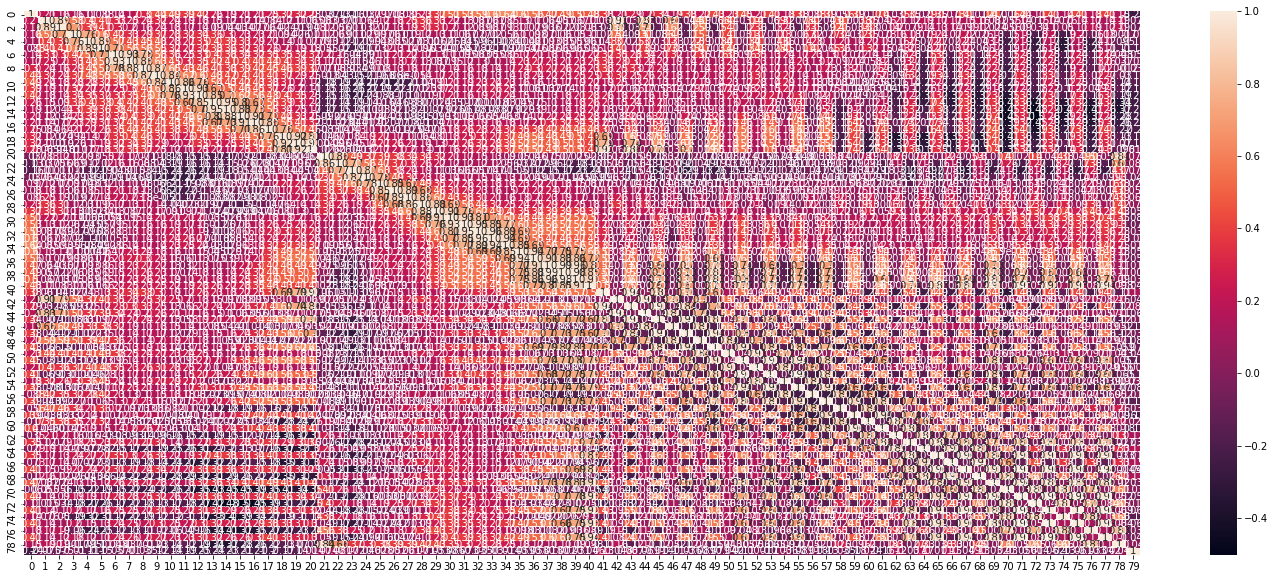

In [ ]:
plt.figure(figsize=(25, 10))
sns.heatmap(temp_train.corr(), annot = True)

In [ ]:
plt.figure(figsize=(25, 10))
sns.heatmap(temp_test.corr(), annot = True)

In [ ]:
plt.plot(temp_train.max(), color = 'green')
plt.plot(temp_train.mean(), color = 'black')
plt.plot(temp_train.min(), color = 'red')
plt.legend()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn = KNeighborsRegressor()
knn.fit(temp_train.drop(79, axis = 1), temp_train[79])

In [ ]:
knn.score(temp_test.drop(79, axis = 1), temp_test[79])

In [ ]:
knn.score(temp_train.drop(79, axis = 1), temp_train[79])

In [ ]:
 knn.fit(temp_train.drop(49, axis = 1), temp_train[49])
 knn.score(temp_test.drop(49, axis = 1), temp_test[49])

In [ ]:
knn.score(temp_train.drop(49, axis = 1), temp_train[49])

In [ ]:
def get_correlation(data, threshold):
    corr_col = set()
    corr = data.corr()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i,j]) > threshold:
                corr_col.add(corr.columns[i])
    return corr_col

def get_uncorr_data(train_data, test_data, threshold):

    corr_columns = get_correlation(pd.DataFrame(train_data), threshold)
    print(f'there are {len(corr_columns)} correlated columns for threshold correlation of {threshold}','\n')

    corrmat = pd.DataFrame(train_data).corr()

    corrdata = corrmat.abs().stack().sort_values(ascending = False)

    corrdata = corrdata[corrdata > 0.95]
    corrdata = corrdata[corrdata < 1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['feature1','feature2', 'value']

    grouped_column_list = []
    correlated_group_list = []
    for column in corrdata['feature1']:
        if column not in grouped_column_list:
            correlated_block = corrdata[corrdata.feature1 == column]
            grouped_column_list = grouped_column_list + list(correlated_block.feature2.unique()) + [column]
            correlated_group_list.append(correlated_block)

    important_columns = []
    for data in correlated_group_list:
        columns = list(data.feature1.unique()) + list(data.feature2.unique())
        important_columns.append(columns[0])

    new_to_drop = list(corr_columns - set(important_columns))

    l = new_to_drop
    columns_to_drop = list()
    for i in l:
        if (i-1 not in columns_to_drop and i+1 not in columns_to_drop):
            columns_to_drop.append(i)
    print(f'total columns which were droped are {len(columns_to_drop)}')

    y_train_grouped_uncorr = pd.DataFrame(y0[0]).drop(columns_to_drop, axis = 1)
    y_test_grouped_uncorr =pd.DataFrame(y_test0[0]).drop(columns_to_drop, axis = 1)
    
    return y_train_grouped_uncorr, y_test_grouped_uncorr

In [ ]:
y_train_grouped_uncorr, y_test_grouped_uncorr = get_uncorr_data(y0[0], y_test0[0], 0.96)

there are 105 correlated columns for threshold correlation of 0.96 

total columns which were droped are 48


In [ ]:
y_train_grouped_uncorr.shape, y_test_grouped_uncorr.shape

In [ ]:
y_train_grouped_uncorr

In [ ]:
temp_train, temp_test = get_uncorr_data(y0[1], y_test0[1], 0.97)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
rf.score(y_train_grouped_uncorr[[2,4]][:20] + y0[0][:,3:4][:20], pd.DataFrame(y0[0])[3][:20])

In [ ]:
rf = RandomForestRegressor(n_estimators=30, random_state=0)
rf.fit(y_train_grouped_uncorr[[2,4]] + y0[0][:,3:4], pd.DataFrame(y0[0])[3])      # + y0[0][:,3:4]
rf.score(y_test_grouped_uncorr[[2,4]] + y_test0[0][:,3:4], pd.DataFrame(y_test0[0])[3])

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf = KFold(n_splits=5)

In [ ]:
score = cross_val_score(RandomForestRegressor(n_estimators=86, random_state=100),y_train_grouped_uncorr[[2,4]] + y0[0][:,3:4], pd.DataFrame(y0[0])[3])

In [ ]:
print(score.mean())
score*100

0.5648762095000448


array([ 0.        , 96.40079786, 88.1641454 , 97.87316149,  0.        ])

In [ ]:
score = cross_val_score(KNeighborsRegressor(n_neighbors=2),y_train_grouped_uncorr[[2,4]] + y0[0][:,3:4], pd.DataFrame(y0[0])[3])

In [ ]:
score

array([1.        , 0.92149014, 0.70398519, 0.97545793, 1.        ])

In [ ]:
score.mean()

0.9201866519541098

In [ ]:
score = cross_val_score(LinearRegression(),y_train_grouped_uncorr[[2,4]] + y0[0][:,3:4], pd.DataFrame(y0[0])[3])
score

array([0.        , 0.97834592, 0.8144736 , 0.97358578, 0.        ])

In [ ]:
# LinearRegression
lr = LinearRegression()
lr.fit(y_train_grouped_uncorr[[2,4]], pd.DataFrame(y0[0])[3])      # + y0[0][:,3:4]
lr.score(y_test_grouped_uncorr[[2,4]], pd.DataFrame(y_test0[0])[3])

0.9620640913017997

In [ ]:
rf = RandomForestRegressor(n_estimators=54, random_state=0)   # 54      + y0[0][:,5:6]
rf.fit(y_train_grouped_uncorr[[4,6]] + y0[0][:,5:6], pd.DataFrame(y0[0])[5])   # 0.9867168654477211
rf.score(y_test_grouped_uncorr[[4,6]] + y_test0[0][:,5:6], pd.DataFrame(y_test0[0])[5])

0.9975069498101776

In [ ]:
rf.score(y_test_grouped_uncorr[[2,4]] + y_test0[0][:,3:4], pd.DataFrame(y_test0[0])[3])

0.996937386217841

In [ ]:
imp_col = list()
droped_col = list()
l = y_train_grouped_uncorr.columns
for i in np.arange(0,110):
    if i not in l:
        droped_col.append(i)
        imp_col.append([i-1,i+1])

In [ ]:
len(imp_col), len(droped_col)

(48, 48)

In [ ]:
rf_score = list()
rf_score_mean = list()
knn_score = list()
knn_score_mean = list()
for i in range(len(droped_col)):
    knn = KNeighborsRegressor(n_neighbors=2)
    rf = RandomForestRegressor(n_estimators=30)
    rf_val_score = cross_val_score(rf, y_train_grouped_uncorr[imp_col[i]] + y0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y0[0])[droped_col[i]])
    #rf_val_score = [int(i[:6]) for i in rf_val_score]
    rf_score.append(list(rf_val_score)*100)
    rf_score_mean.append(rf_val_score.mean()*100)
    knn_val_score = cross_val_score(knn, y_train_grouped_uncorr[imp_col[i]] + y0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y0[0])[droped_col[i]])
    l = []
    for i in knn_val_score:
        try:
            l.append(int(str(i)[:6]))
        except:
            l.append(i)
    #[try int(str(i)[:6]) except list(i)*100 for i in knn_val_score]
    knn_score.append(l*100)
    knn_score_mean.append(np.array(l).mean()*100)
    #rf.fit(y_train_grouped_uncorr[imp_col[i]] + y0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y0[0])[droped_col[i]])      # + y0[0][:,3:4]
    #score = rf.score(y_test_grouped_uncorr[imp_col[i]] + y_test0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y_test0[0])[droped_col[i]])

In [ ]:
len(rf_score), len(knn_score), len(rf_score_mean), len(knn_score_mean)

(48, 48, 48, 48)

In [ ]:
d = dict()
d['RandomForest_score'] = rf_score
d['RandomForest_mean_score'] = rf_score_mean
d['KNN_score'] = knn_score
d['KNN_score_mean'] = knn_score_mean
df_score = pd.DataFrame(d)

In [ ]:
df_score

,RandomForest_score,RandomForest_mean_score,KNN_score,KNN_score_mean
0,"[0.0, 0.8738109546152196, -0.21912233673759762...",32.835550,"[1.0, 0.8449633986759636, 0.28967318187006685,...",82.137478
1,"[0.0, 0.9096771587459608, -0.5855304952599723,...",26.298213,"[1.0, 0.8316644686890403, -0.9919374912743647,...",56.621431
2,"[0.7752781035552953, 0.890919110455526, 0.3073...",78.431184,"[0.7447166944614382, 0.9244557673578813, 0.346...",74.358938
3,"[0.9973816283459508, 0.9335445035604522, 0.334...",79.567433,"[0.9506269146154721, 0.9427935214580928, 0.122...",75.448515
4,"[0.9991116517275628, 0.9982655827483671, 0.820...",83.627799,"[0.9886676672685325, 0.9811438530849415, 0.870...",84.066589
5,"[0.9966289914834628, 0.9973918597954208, 0.983...",89.927993,"[0.9903855781885608, 0.9953443676664263, 0.991...",90.198925
6,"[0.9894416270372032, 0.9971637960195185, 0.988...",97.818339,"[0.996642134489559, 0.9975593913576154, 0.9941...",98.979898
7,"[0.9995832872185716, 0.9829126707592158, 0.989...",98.921116,"[0.9904740376978407, 0.9866302791606192, 0.983...",98.815216
8,"[0.9962473044181109, 0.9928341088714148, 0.857...",93.491983,"[0.985150367406781, 0.9492498321829339, 0.9072...",95.410751
9,"[0.9924054906770458, 0.932753808700516, 0.9601...",96.890581,"[0.9865941606333762, 0.8266686073891918, 0.917...",93.927997


In [ ]:
temp = df_score[df_score['KNN_score_mean'] < 95.0]  
temp = df_score[df_score['RandomForest_mean_score'] < 95.0]
print(len(temp))
temp

41


,RandomForest_score,RandomForest_mean_score,KNN_score,KNN_score_mean
0,"[0.0, 0.8738109546152196, -0.21912233673759762...",32.835550,"[1.0, 0.8449633986759636, 0.28967318187006685,...",82.137478
1,"[0.0, 0.9096771587459608, -0.5855304952599723,...",26.298213,"[1.0, 0.8316644686890403, -0.9919374912743647,...",56.621431
2,"[0.7752781035552953, 0.890919110455526, 0.3073...",78.431184,"[0.7447166944614382, 0.9244557673578813, 0.346...",74.358938
3,"[0.9973816283459508, 0.9335445035604522, 0.334...",79.567433,"[0.9506269146154721, 0.9427935214580928, 0.122...",75.448515
4,"[0.9991116517275628, 0.9982655827483671, 0.820...",83.627799,"[0.9886676672685325, 0.9811438530849415, 0.870...",84.066589
5,"[0.9966289914834628, 0.9973918597954208, 0.983...",89.927993,"[0.9903855781885608, 0.9953443676664263, 0.991...",90.198925
8,"[0.9962473044181109, 0.9928341088714148, 0.857...",93.491983,"[0.985150367406781, 0.9492498321829339, 0.9072...",95.410751
10,"[0.9975173733256536, 0.8638679127739127, 0.957...",85.747308,"[0.991136107858855, 0.8343972991881361, 0.9657...",85.557625
11,"[0.9939937987633309, 0.922593461837393, 0.9455...",81.991962,"[0.9949293495804475, 0.9108378889044383, 0.965...",82.383826
12,"[0.9949964673730256, 0.9766757502610722, 0.954...",80.540116,"[0.9913436796104151, 0.9751331425179728, 0.979...",81.625582


In [ ]:
temp.index

Int64Index([ 0,  1,  2,  3,  4,  5,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 39, 40,
            41, 42, 43, 44, 45, 46, 47],
           dtype='int64')

In [ ]:
print(len(df_score[df_score['KNN_score_mean'] < df_score['RandomForest_mean_score']]))
df_score[df_score['KNN_score_mean'] < df_score['RandomForest_mean_score']]

14


,RandomForest_score,RandomForest_mean_score,KNN_score,KNN_score_mean
2,"[0.7752781035552953, 0.890919110455526, 0.3073...",78.431184,"[0.7447166944614382, 0.9244557673578813, 0.346...",74.358938
3,"[0.9973816283459508, 0.9335445035604522, 0.334...",79.567433,"[0.9506269146154721, 0.9427935214580928, 0.122...",75.448515
7,"[0.9995832872185716, 0.9829126707592158, 0.989...",98.921116,"[0.9904740376978407, 0.9866302791606192, 0.983...",98.815216
9,"[0.9924054906770458, 0.932753808700516, 0.9601...",96.890581,"[0.9865941606333762, 0.8266686073891918, 0.917...",93.927997
10,"[0.9975173733256536, 0.8638679127739127, 0.957...",85.747308,"[0.991136107858855, 0.8343972991881361, 0.9657...",85.557625
18,"[0.964942852685789, 0.9301721396942958, 0.8998...",84.807499,"[0.9551124472648552, 0.9035084850092473, 0.916...",84.486629
23,"[0.9982370872344386, 0.9640297393065401, 0.829...",84.722900,"[0.999156098123895, 0.9705493360196612, 0.8205...",83.983462
32,"[0.9977689008255634, 0.97639195034802, 0.54028...",86.189346,"[0.9969296951182222, 0.9313989295290127, 0.553...",82.671576
36,"[0.9972493923639437, 0.9364764552863012, 0.983...",97.217704,"[0.9945264267559784, 0.9510295790054608, 0.989...",97.031961
38,"[0.9958154837090636, 0.9518646057312755, 0.912...",96.025712,"[0.9881454232293629, 0.8955127706489532, 0.910...",95.052843


In [ ]:
cross_val_score(KNeighborsRegressor(n_neighbors=2), y_train_grouped_uncorr[imp_col[4]] + y0[0][:,droped_col[4]:imp_col[4][1]], pd.DataFrame(y0[0])[droped_col[4]]).mean()

0.8406658902680111

In [ ]:
cross_val_score(KNeighborsRegressor(n_neighbors=3), y_train_grouped_uncorr[imp_col[4]] + y0[0][:,droped_col[4]:imp_col[4][1]], pd.DataFrame(y0[0])[droped_col[4]]).mean()

0.8521209713653963

In [ ]:
cross_val_score(KNeighborsRegressor(n_neighbors=4), y_train_grouped_uncorr[imp_col[4]] + y0[0][:,droped_col[4]:imp_col[4][1]], pd.DataFrame(y0[0])[droped_col[4]])

array([0.99740512, 0.96874898, 0.92789959, 0.36630895, 0.99722464])

In [ ]:
cross_val_score(KNeighborsRegressor(n_neighbors=4), y_train_grouped_uncorr[imp_col[4]] + y0[0][:,droped_col[4]:imp_col[4][1]], pd.DataFrame(y0[0])[droped_col[4]]).mean()

0.8515174556765001

In [ ]:
cross_val_score(KNeighborsRegressor(n_neighbors=8), y_train_grouped_uncorr[imp_col[4]] + y0[0][:,droped_col[4]:imp_col[4][1]], pd.DataFrame(y0[0])[droped_col[4]])

array([0.98069946, 0.93708926, 0.85020758, 0.35487382, 0.98781524])

In [ ]:
cross_val_score(KNeighborsRegressor(n_neighbors=4), y_train_grouped_uncorr[imp_col[41]] + y0[0][:,droped_col[41]:imp_col[41][1]], pd.DataFrame(y0[0])[droped_col[41]]).mean()

0.9214189558131366

In [ ]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(y_train_grouped_uncorr[imp_col[4]] + y0[0][:,droped_col[4]:imp_col[4][1]], pd.DataFrame(y0[0])[droped_col[4]])
knn.score(y_test_grouped_uncorr[imp_col[4]] + y_test0[0][:,droped_col[4]:imp_col[4][1]], pd.DataFrame(y_test0[0])[droped_col[4]])

0.9931258135787038

In [ ]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(y_train_grouped_uncorr[imp_col[41]] + y0[0][:,droped_col[41]:imp_col[41][1]], pd.DataFrame(y0[0])[droped_col[41]])
knn.score(y_test_grouped_uncorr[imp_col[41]] + y_test0[0][:,droped_col[41]:imp_col[41][1]], pd.DataFrame(y_test0[0])[droped_col[41]])

0.9956956198830462

In [ ]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(y_train_grouped_uncorr[imp_col[1]] + y0[0][:,droped_col[1]:imp_col[1][1]], pd.DataFrame(y0[0])[droped_col[1]])
knn.score(y_test_grouped_uncorr[imp_col[1]] + y_test0[0][:,droped_col[1]:imp_col[1][1]], pd.DataFrame(y_test0[0])[droped_col[1]])

0.9936246468930225

In [ ]:
l = y_train_grouped_uncorr.columns
scores = []
for i in np.arange(0,110):
    if i not in l:
        rf.fit(y_train_grouped_uncorr[[i-1,i+1]] + y0[0][:,i:i+1], pd.DataFrame(y0[0])[i])   # 0.9867168654477211
        score = rf.score(y_test_grouped_uncorr[[i-1, i+1]] + y_test0[0][:,i:i+1], pd.DataFrame(y_test0[0])[i])
        scores.append(score)
        print(score)

0.9976751830479199
0.9975941798994016
0.9958286045513309
0.9891999680711338
0.9978574069165039
0.9984266041593947
0.9980641255140185
0.9958532488261864
0.9981786194024522
0.998341771860017
0.9985276172854881
0.9979248289914777
0.9980795215615209
0.9976720299482496
0.997513951400123
0.9981263387612231
0.9978590043740692
0.9954887768587305
0.997758496810245
0.9963594504272147
0.9971112500966226
0.9968545057182755
0.9587923308781129
0.9420887051723864
0.9725214079706449
0.9866310736004069
0.955606264950944
0.992592021217328
0.9975317078319776
0.9939607759849552
0.9979434821250034
0.998321921635498
0.9968112431497158
0.9977055731255079
0.9969739527738712
0.997917945346594
0.992625134399939
0.9952276260358358
0.998177233669723
0.9969753232907627
0.9984613096687718
0.9977802221405698
0.9983570039113101
0.9969527234118059
0.9966973030701176
0.9967708641133366
0.9882836446717113
0.9922968432919559


In [ ]:
rf_score = list()
rf_score_mean = list()
knn_score = list()
knn_score_mean = list()
knn_neighbors = list()
for i in range(len(droped_col)):
    neighbors = 2
    estimators = 60
    rf = RandomForestRegressor(n_estimators=estimators)
    rf_val_score = cross_val_score(rf, y_train_grouped_uncorr[imp_col[i]] + y0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y0[0])[droped_col[i]])
    #rf_val_score = [int(i[:6]) for i in rf_val_score]
    rf_score.append(list(rf_val_score)*100)
    rf_score_mean.append(rf_val_score.mean()*100)
    knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=neighbors), y_train_grouped_uncorr[imp_col[i]] + y0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y0[0])[droped_col[i]])
    mean = knn_val_score.mean()
    m = list()
    n = list()
    p = list()
    if mean < 0.95:
        for k, j in enumerate([4, 6, 8, 10,12, 24]):
            scr = cross_val_score(KNeighborsRegressor(n_neighbors=j), y_train_grouped_uncorr[imp_col[i]] + y0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y0[0])[droped_col[i]])
            m.append(j)
            n.append(scr.mean())
            p.append(list(scr))
        max_arg = np.array(n).argmax()
        knn_neighbors.append(m[max_arg])
        knn_val_score = p[max_arg]
    else:
        knn_neighbors.append(4)
    #[try int(str(i)[:6]) except list(i)*100 for i in knn_val_score]
    knn_score.append(knn_val_score*100)
    knn_score_mean.append(np.array(knn_val_score).mean()*100)
    #rf.fit(y_train_grouped_uncorr[imp_col[i]] + y0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y0[0])[droped_col[i]])      # + y0[0][:,3:4]
    #score = rf.score(y_test_grouped_uncorr[imp_col[i]] + y_test0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y_test0[0])[droped_col[i]])

In [ ]:
d = dict()
d['RandomForest_score'] = rf_score
d['RandomForest_mean_score'] = rf_score_mean
d['KNN_score'] = knn_score
d['KNN_score_mean'] = knn_score_mean
d['knn_neighbors'] = knn_neighbors
df_score = pd.DataFrame(d)
df_score

,RandomForest_score,RandomForest_mean_score,KNN_score,KNN_score_mean,knn_neighbors
0,"[0.0, 0.904491778053403, -0.09643483282386422,...",35.897228,"[1.0, 0.8065986346415007, 0.12849269366510574,...",78.396748,4
1,"[0.0, 0.9318075110505479, -0.8269257361648035,...",21.915064,"[1.0, 0.9169024405308877, -0.9739647751571398,...",58.673891,4
2,"[0.7091456572668753, 0.9023726300540799, 0.360...",78.350203,"[0.41546477895079204, 0.8421770354511008, 0.35...",59.789436,4
3,"[0.9944052907123085, 0.9785528301403412, 0.330...",82.044878,"[0.9803144251163393, 0.9545324671728674, 0.397...",82.371961,4
4,"[0.9985065620491007, 0.9987370805411231, 0.745...",82.184602,"[0.997405115133923, 0.9687489786327634, 0.9278...",85.151746,4
5,"[0.9976176230692694, 0.9904545689694169, 0.976...",90.184322,"[0.9981919467302641, 0.9776459093474066, 0.992...",90.356320,4
6,"[0.9949066177947671, 0.9974620159221231, 0.989...",97.786620,"[99.66421344895589, 99.75593913576154, 99.4171...",98.979898,4
7,"[0.9990791967855343, 0.994251258399117, 0.9883...",99.107646,"[99.04740376978407, 98.66302791606192, 98.3366...",98.815216,4
8,"[0.9934965622886669, 0.9840607222519545, 0.855...",93.078077,"[98.5150367406781, 94.92498321829339, 90.72232...",95.410751,4
9,"[0.9959298321960122, 0.9502159745344028, 0.956...",97.104052,"[0.9555416922613017, 0.8757511741823439, 0.969...",95.600480,4


RandomForestRegressor is overfitting and not performing well.


KNN seems to be a good fit

In [ ]:
import pickle

In [ ]:
temp_score = list()
for i in range(len(droped_col)):
    knn = KNeighborsRegressor(n_neighbors=knn_neighbors[i])
    temp_model= knn.fit(y_train_grouped_uncorr[imp_col[i]] + y0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y0[0])[droped_col[i]])
    temp_score.append(knn.score(y_test_grouped_uncorr[imp_col[i]] + y_test0[0][:,droped_col[i]:imp_col[i][1]], pd.DataFrame(y_test0[0])[droped_col[i]]))
    output = open('/content/drive/MyDrive/Colab Notebooks/KNN model for CNN'+'knn_model_' + str(i)+'.pkl', 'wb')
    pickle.dump(i, output)

In [ ]:
temp_score

[0.9948381960355117,
 0.9936246468930225,
 0.9926793632161447,
 0.9852812495140701,
 0.9931258135787038,
 0.996484891769361,
 0.9954102531949489,
 0.9955614919779533,
 0.9976549187482157,
 0.9984055498567291,
 0.9965883329460342,
 0.9968091166203399,
 0.9967885977478272,
 0.9977521313037433,
 0.9965069202977805,
 0.9971177366533919,
 0.9905896864190147,
 0.9847483312547459,
 0.9885394549621671,
 0.9914648413142627,
 0.992323049462557,
 0.995843971054989,
 0.9519112813049269,
 0.9353905815490806,
 0.9628780543125179,
 0.9844768896789258,
 0.9436105395655054,
 0.9819684476136895,
 0.9832117162595991,
 0.9888770912471884,
 0.9961426854377341,
 0.9974942939767418,
 0.9956141701298132,
 0.9958344525919832,
 0.996012845201106,
 0.9953296416604859,
 0.9939118691409884,
 0.9932831014492127,
 0.9966541656182633,
 0.9977837158590883,
 0.9976112872364647,
 0.9956956198830462,
 0.9970256248140149,
 0.9929755585874496,
 0.995432757707316,
 0.9956895608436415,
 0.9961500070882425,
 0.982511036716320

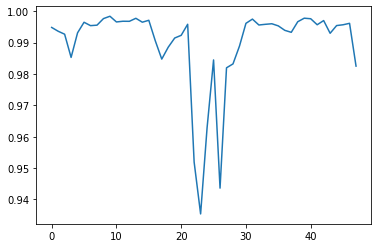

In [ ]:
plt.plot(temp_score)

In [ ]:
len(knn_neighbors)

48

In [ ]:
from google.colab import files

In [ ]:
#for i in range(len(knn_neighbors)):
 #   files.download('/content/knn_model_'+str(i) + '.pkl')

In [ ]:
print(knn_neighbors)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 6, 4, 4]


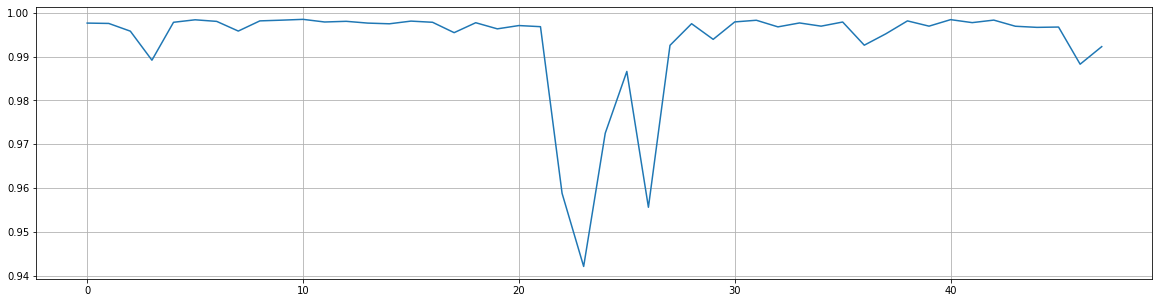

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,len(scores)), scores)
plt.grid()

In [ ]:
x = np.empty((66,110,65,3))
for i in range(66):
    for j,k in enumerate(y_train_grouped_uncorr.columns):
        for m in range(3):
            x[i,:,j, m] = x_train_0[i, :, k]

#y = y_train_0[:,:,:]  
#x.shape, y.shape

In [ ]:
y = np.empty((66,110,65,110))
for i in range(66):
    for j,k in enumerate(y_train_grouped_uncorr.columns):
        y[i,:, j, :] = y_train_0[i,:, k, :]

In [ ]:
x.shape, y.shape

((66, 110, 65, 3), (66, 110, 65, 110))

In [ ]:
x[0].max()

10.0

In [ ]:
y_train_grouped_uncorr.shape

(110, 62)

In [ ]:
y_train_grouped_uncorr.columns

Int64Index([  0,   1,   2,   3,   4,   6,   8,   9,  11,  13,  15,  17,  19,
             20,  22,  24,  26,  27,  29,  31,  33,  35,  36,  38,  40,  42,
             44,  46,  48,  50,  52,  54,  56,  58,  60,  62,  64,  65,  67,
             69,  71,  72,  74,  76,  78,  80,  82,  84,  86,  87,  89,  91,
             93,  94,  96,  98, 100, 102, 104, 105, 107, 109],
           dtype='int64')

In [ ]:
x = x + 10
y = y + 10

In [ ]:
x[0].min(), y[0].min()

(9.969696081899333, 9.937575341420615)

In [ ]:
vgg = VGG16(input_shape=(110,65,3), include_top=False)
vgg.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 110, 65, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 110, 65, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 110, 65, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 55, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 55, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 55, 32, 128)       147584    
______________________________________________________________

In [ ]:
for layer in vgg.layers[:10]:
    layer.trainable = False
input = vgg.layers[:5]
model = Sequential()
model.add(Conv2D(filters=3, kernel_size=(3,3), padding="same", activation='relu', input_shape = (110,110,3)))    #LeakyReLU(alpha=1)
model.add(input[0])
model.add(input[1])
model.add(input[2])
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
#model.add(x[3])
#model.add(x[4])
#model = Model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 3)       84        
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 110)     63470     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 110)     109010    
Total params: 211,284
Trainable params: 172,564
Non-trainable params: 38,720
_____________________________________________

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer= 'adam', metrics = ['accuracy']) 
history = model.fit(x, y, batch_size=32, epochs = 20)

Epoch 1/20
3/3 [==============================] - 14s 3s/step - loss: nan - accuracy: 0.1039
Epoch 2/20
3/3 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.2430
Epoch 3/20
3/3 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.2446
Epoch 4/20
3/3 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.2407
Epoch 5/20
3/3 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.2424
Epoch 6/20
3/3 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.2421
Epoch 7/20
3/3 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.2440
Epoch 8/20
3/3 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.2447
Epoch 9/20
3/3 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.2413
Epoch 10/20
3/3 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.2437
Epoch 11/20
3/3 [==============================] - 13s 3s/step - loss

KeyError: ignored

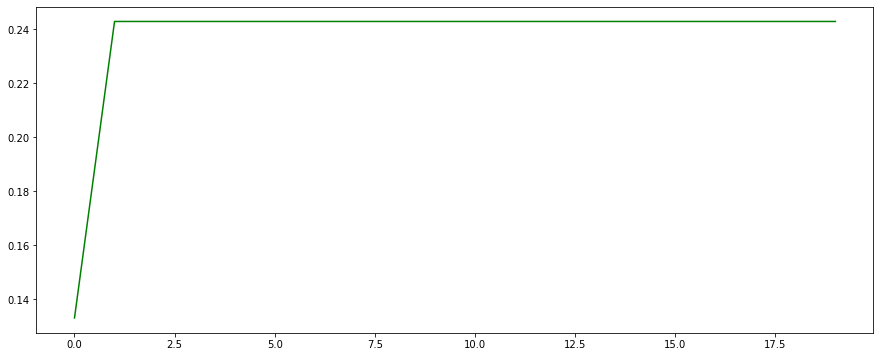

In [ ]:
plot_accuracy_curve(history, 20)

KeyError: ignored

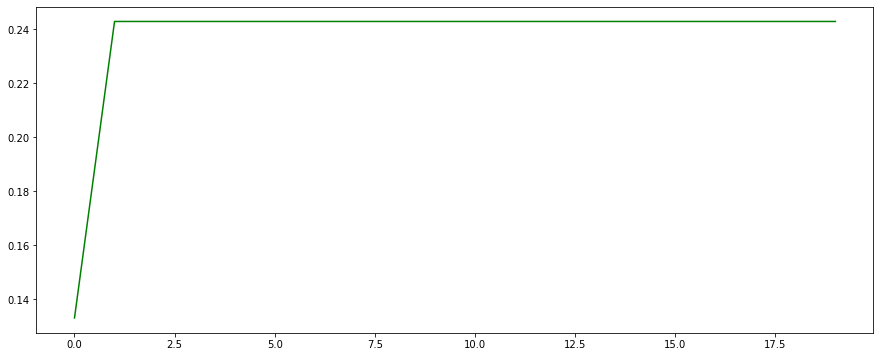

In [ ]:
plot_learning_curve(history, 20)